# Emsembles
Machine Learning, hw#4

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [ ]:
# establish seed and silence warnings
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

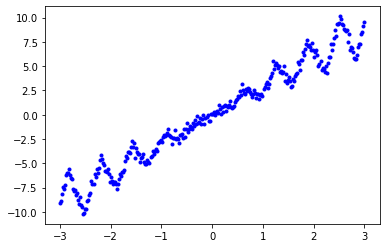

In [ ]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [ ]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

In [ ]:
from sklearn.metrics import mean_squared_error

# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions2(tree_reg, X, y, ax, i,
                                 axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    y_true = (3 + 2/np.pi * np.arcsin(np.cos(10 * x1))) * x1
    mse = mean_squared_error(y_true, y_pred)
    ax.set_title(f'max depth: {i+1}, MSE: {mse:.3f}')

    ax.plot(x1, y_pred, linewidth=2)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

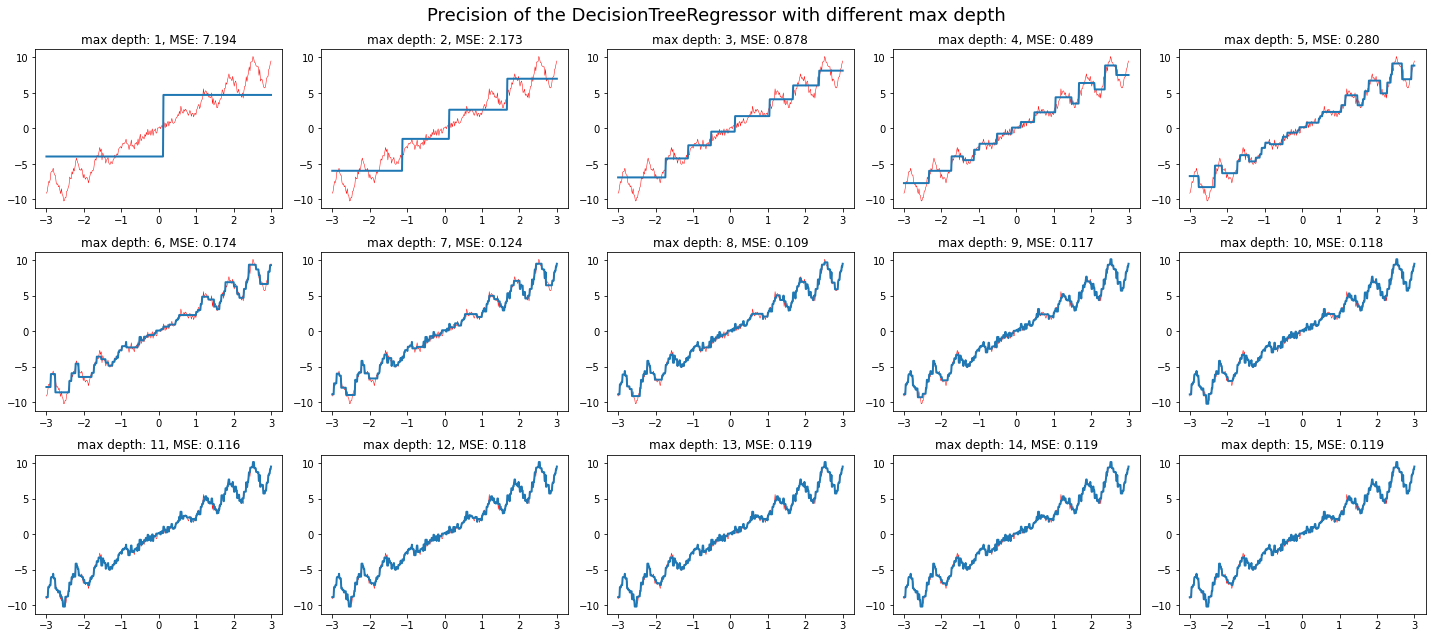

In [ ]:
fig, ax = plt.subplots(3,5, figsize=(20,9))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

# iterate over the max depth to analyse its influence
for i in range(15):
  clf = DecisionTreeRegressor(max_depth=i+1)
  clf.fit(X_train, y_train)
  ax[i//5, i%5].plot(X.reshape(-1), y.reshape(-1), 'r', linewidth=0.5)
  plot_regression_predictions2(clf, X_test, y_test, ax[i//5, i%5], i) 

plt.suptitle('Precision of the DecisionTreeRegressor with different max depth',
             fontsize=18)
plt.tight_layout()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
import math 

def mu_maker(p, k=101):
  def inner_mu_maker(p, i, k):
    return math.comb(k, i) * pow(p, i) * pow(1-p, k-i)
  return sum([inner_mu_maker(p, i, k) for i in range(k//2 + 1, k+1)])

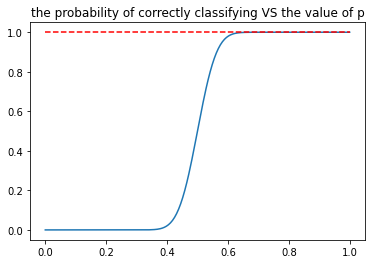

In [ ]:
m = 300
X = np.linspace(0, 1, m).reshape(-1, 1)
y = mu_maker(X)

plt.plot(X, y); plt.plot(X, np.ones_like(X), 'r--')
plt.title('the probability of correctly classifying VS the value of p');

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

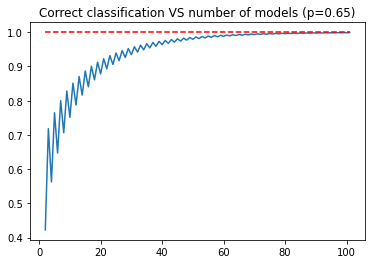

In [ ]:
X = np.arange(2, 102)
y = [mu_maker(p=0.65, k=j) for j in X]

plt.plot(X, y); plt.plot(X, np.ones_like(X), 'r--')
plt.title('Correct classification VS number of models (p=0.65)');

Опишите ваши наблюдения:

* successful classification is possible only if a model can successfully predict more than a half cases;
* successful classification hits almost `p=1` if the amount of models is more than 60ish (and all of them are not genious aka `p=0.65`)

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [ ]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
          np.random.seed(self.random_state + i)
          # generate a list of features to slice
          feat_ids_by_tree_step = np.random.choice(np.arange(X.shape[1]), 
                                                   size=self.max_features, 
                                                   replace=False)
          self.feat_ids_by_tree.append(feat_ids_by_tree_step)
          # generate a list of rows to slice
          pseudo_slice = np.random.choice(np.arange(len(X)), 
                                          size=len(X), replace=True)

          clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                       max_features=self.max_features,
                                       random_state=self.random_state+i)
          self.trees.append(clf.fit(X[pseudo_slice][:, feat_ids_by_tree_step], 
                                    y[pseudo_slice]))

          return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        y_pred_storage = []

        for feats, tree in zip(self.feat_ids_by_tree, self.trees):
          y_pred_storage.append(tree.predict_proba(X[:, feats]))

        return np.average(y_pred_storage, axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    # plt.xlabel(r"$x_1$", fontsize=18)
    # plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

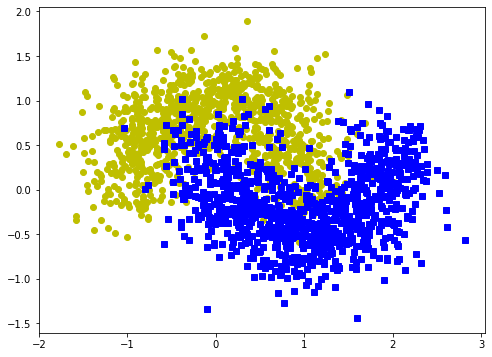

In [ ]:
X, y = datasets.make_moons(n_samples=2000, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

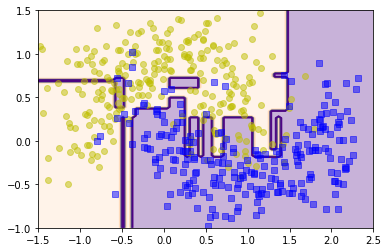

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

trial = RandomForestClassifierCustom(max_depth=8, max_features=X.shape[1], 
                                     random_state=SEED)
trial.fit(X_train, y_train)

plot_decision_boundary(trial, X_test, y_test)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
def plot_decision_boundary2(clf, X, y, ax, axes=[-1.5, 2.5, -1, 1.5], 
                            alpha=0.5, contour=True):
  
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)

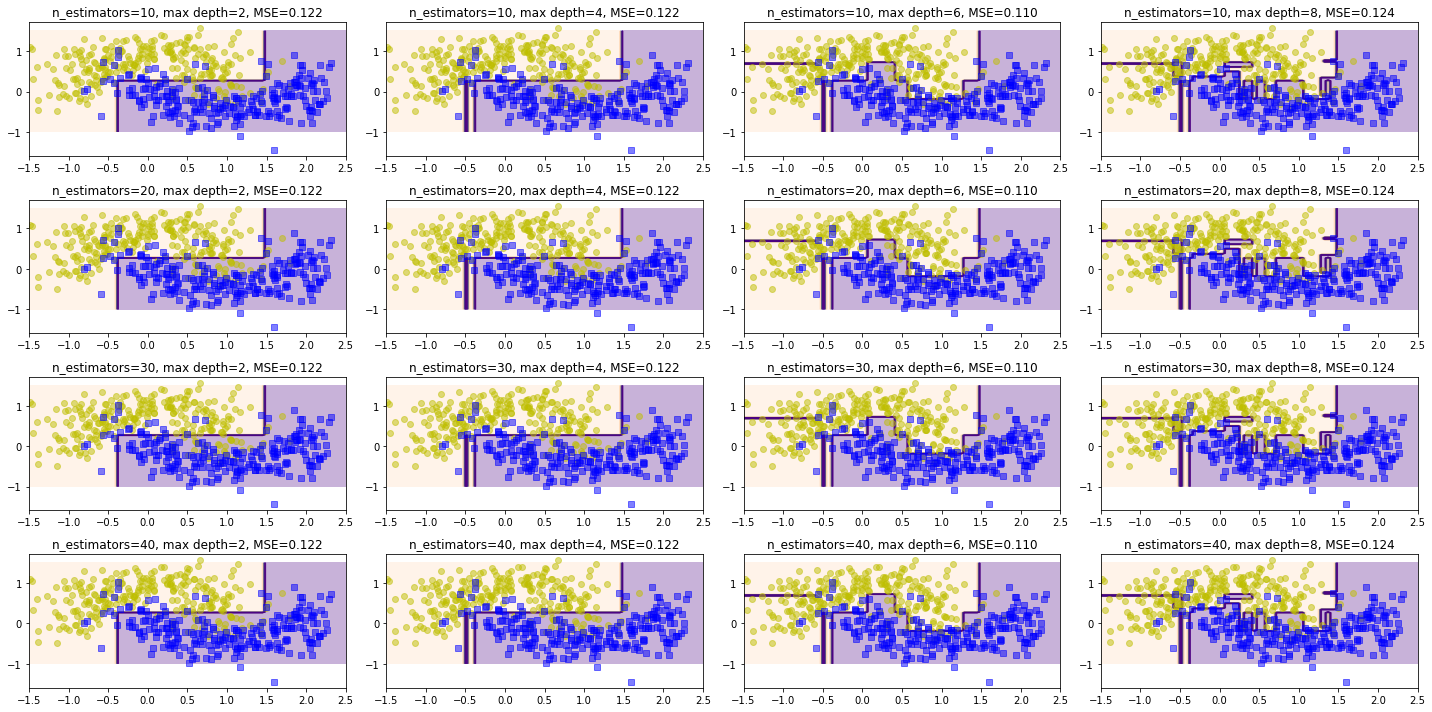

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(20,10))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

for i in range(16):
  trial = RandomForestClassifierCustom(n_estimators=10*(i//4 + 1), max_depth=(i%4 +1)*2, 
                                       max_features=X.shape[1], random_state=SEED)
  trial.fit(X_train, y_train)

  plot_decision_boundary2(trial, X_test, y_test, ax[i//4, i%4])
  mse = mean_squared_error(y_test, trial.predict(X_test))
  ax[i//4, i%4].set_title(f'n_estimators={10*(i//4 + 1)}, max depth={(i%4 +1)*2}, MSE={mse:.3f}')

plt.tight_layout()

* It seems that a number of estimators is not so crucial in comparison to the max depth

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [ ]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [ ]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
X.shape

(569, 30)

In [ ]:
df = pd.DataFrame()

for i in range(5, 31, 5):
  rf = RandomForestClassifier(max_features=i)
  rf.fit(X_train, y_train)
  df[f'max_features={i}'] = base_model_pair_correlation(rf, X_test)

<Axes: >

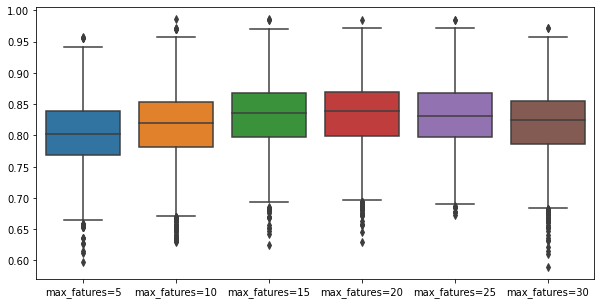

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

<Axes: >

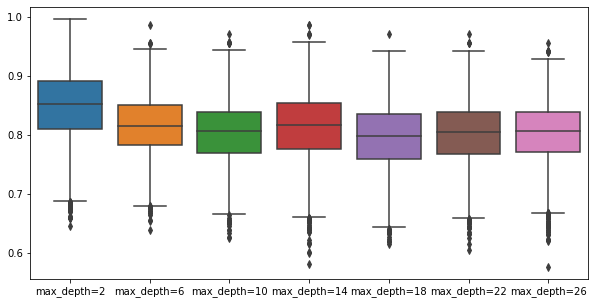

In [ ]:
df = pd.DataFrame()

for i in range(2,30,4):
  rf = RandomForestClassifier(max_depth=i)
  rf.fit(X_train, y_train)
  df[f'max_depth={i}'] = base_model_pair_correlation(rf, X_test)

plt.figure(figsize=(10,5))
sns.boxplot(data=df)

Опишите ваши наблюдения:

* The variation of the result is not sufficient with different max features. Yet it could give the improvement of ~4%. There is an optimum for that
* There is an optimum for max depth too. In general, the recignition rate is lower with higher max depth but at some point the decrease becomes a plateu

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [492]:
! gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [494]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]

from sklearn.preprocessing import StandardScaler
# create a StandardScaler object
scaler = StandardScaler()
# fit the scaler to your data
scaler.fit(X)
# transform your data
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=SEED)
X_train[10]

array([-1.03300228,  0.68100522,  0.03203122, -0.20696359,  1.19307747,
       -0.41763453, -1.00583187,  0.89005288, -0.69663055, -0.89686172,
        0.97635214, -0.71442887, -0.51292188])

In [ ]:
X_train.shape

(227, 13)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [495]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [496]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
from sklearn.base import clone

cloned_funcs = [(name, clone(estimator)) for name, estimator in base_models]
voting_hard = VotingClassifier(estimators=cloned_funcs, voting='hard')
voting_soft = VotingClassifier(estimators=cloned_funcs, voting='soft')

base_models.append(('voting_hard', voting_hard))
base_models.append(('voting_soft', voting_soft))

for name, model in base_models:
  model.fit(X_train, y_train)

print('A score by cross-validation:')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

A score by cross-validation:
DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.8401660280970625
SVC: 0.848553601815088
SVC: 0.8527520792449303
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8067331454179246
XGBRFClassifier: 0.8426829268292683
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subs

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [497]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((id(est1), id(est2), pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [498]:
est_names = [f'{type(model).__name__}_{index}' for index, model in enumerate(voting_soft.estimators_)]
est_zip = dict(zip([id(i) for i in voting_soft.estimators_], est_names))
est_zip

{140282205525616: 'DecisionTreeClassifier_0',
 140282205527584: 'RandomForestClassifier_1',
 140282205525280: 'ExtraTreesClassifier_2',
 140282198909904: 'KNeighborsClassifier_3',
 140282205525376: 'SVC_4',
 140282193486512: 'SVC_5',
 140282193487664: 'CatBoostClassifier_6',
 140282205526528: 'LGBMClassifier_7',
 140282193489536: 'LGBMClassifier_8',
 140282197313280: 'XGBClassifier_9',
 140282193561968: 'XGBRFClassifier_10',
 140282193563504: 'LogisticRegression_11',
 140282193561056: 'GaussianNB_12'}

In [499]:
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
df = pd.DataFrame(data, columns=["parameter1", "parameter2", "value"])
for i in df.columns[:2]:
  df[i] = df[i].apply(lambda x: est_zip[x])
df

,parameter1,parameter2,value
0,DecisionTreeClassifier_0,RandomForestClassifier_1,0.812213
1,DecisionTreeClassifier_0,ExtraTreesClassifier_2,0.774954
2,DecisionTreeClassifier_0,KNeighborsClassifier_3,0.638683
3,DecisionTreeClassifier_0,SVC_4,0.718559
4,DecisionTreeClassifier_0,SVC_5,0.730831
...,...,...,...
73,XGBClassifier_9,LogisticRegression_11,0.820771
74,XGBClassifier_9,GaussianNB_12,0.718552
75,XGBRFClassifier_10,LogisticRegression_11,0.818162
76,XGBRFClassifier_10,GaussianNB_12,0.735017


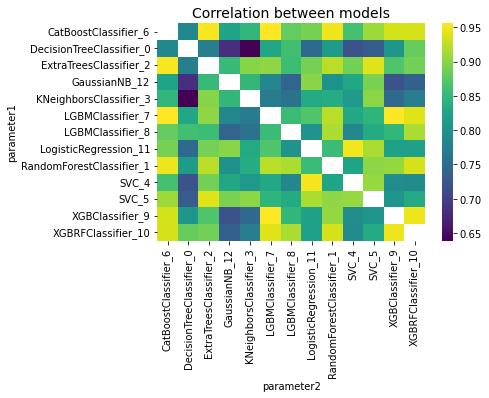

In [ ]:
df1 = df.copy(deep=True)
df1['parameter1'], df1['parameter2'] = df1['parameter2'], df1['parameter1']

df2 = pd.concat([df,df1])

sns.heatmap(data=df2.pivot(index='parameter1', columns='parameter2', values='value'), 
            cmap='viridis').set_title('Correlation between models', fontsize=14);

In [ ]:
b = []
for i in df2['parameter1'].unique():
  a = df2.query('parameter1 == @i & parameter2 not in ["SVC_5", "KNeighborsClassifier_3"]')
  b.append((sum(a.value), i))

print(*sorted(b), sep='\n')  

(7.863843795611497, 'GaussianNB_12')
(7.897345660053551, 'DecisionTreeClassifier_0')
(8.269868109521727, 'SVC_4')
(8.454725199837165, 'LGBMClassifier_8')
(8.537852962191023, 'LogisticRegression_11')
(8.593814067743514, 'XGBClassifier_9')
(8.750132780083211, 'KNeighborsClassifier_3')
(8.790437856856299, 'XGBRFClassifier_10')
(8.795508691323672, 'ExtraTreesClassifier_2')
(8.837819653168468, 'RandomForestClassifier_1')
(8.838911709085913, 'LGBMClassifier_7')
(8.966982813014567, 'CatBoostClassifier_6')
(9.51018119972355, 'SVC_5')


In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
from sklearn.base import clone
import time

cloned_funcs = [(name, clone(estimator)) for name, estimator in base_models]
voting_hard = VotingClassifier(estimators=cloned_funcs, voting='hard')
voting_soft = VotingClassifier(estimators=cloned_funcs, voting='soft')

base_models.append(('voting_hard', voting_hard))
base_models.append(('voting_soft', voting_soft))

for name, model in base_models:
  start = time.time()
  model.fit(X_train, y_train)
  print(time.time() - start, model.__class__.__name__)

print('A score by cross-validation:')
## END YOUR CODE HERE ##

for model in [voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

0.0016696453094482422 DecisionTreeClassifier
0.07984089851379395 RandomForestClassifier
0.13574886322021484 ExtraTreesClassifier
0.0010712146759033203 KNeighborsClassifier
0.015574932098388672 SVC
0.011410951614379883 SVC
0.890139102935791 CatBoostClassifier
0.03660726547241211 LGBMClassifier
0.016864776611328125 LGBMClassifier
0.044161081314086914 XGBClassifier
0.04303336143493652 XGBRFClassifier
0.0018780231475830078 LogisticRegression
0.0010657310485839844 GaussianNB
1.2641217708587646 VotingClassifier
1.2750160694122314 VotingClassifier
A score by cross-validation:
VotingClassifier: 0.8378306061541628
VotingClassifier: 0.8458575300038715


In [500]:
def tryer():
  score_max = []
  for j in range(1, 2**10):
    binary = format(j, '010b')

    dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
    rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
    etc = ExtraTreesClassifier(random_state=SEED)
    knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
    svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
    svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
    cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
    lgbm = lightgbm.LGBMClassifier(random_state=SEED)
    lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
    xgb = xgboost.XGBClassifier(random_state=SEED)
    xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
    lr = LogisticRegression(solver='liblinear', max_iter=10000)
    nb = GaussianNB()

    base_models = [("DT", dt), 
                  #  ("LGBM_RF", lgbm_rf),
                   ("RF", rf), 
                  #("ETC", etc), 
                   ("KNN", knn), 
                   ("SVC_LIN", svc_lin), 
                   ("SVC_RBF", svc_rbf), 
                   ("CAT", cat), 
                   ("LGBM", lgbm), 
                   ("XGB", xgb), 
                   #("XGB_RF", xgb_rf), 
                   ("LR", lr), 
                   ("NB", nb)
                  ]

    bool_list = [bool(int(i)) for i in binary]
    base_models = [x for i, x in enumerate(base_models) if bool_list[i]]            

    cloned_funcs = [(name, clone(estimator)) for name, estimator in base_models]
    # voting_hard = VotingClassifier(estimators=cloned_funcs, voting='hard')
    voting_soft = VotingClassifier(estimators=cloned_funcs, voting='soft')

    # base_models.append(('voting_hard', voting_hard))
    base_models.append(('voting_soft', voting_soft))

    for name, model in base_models:
      model.fit(X_train, y_train)

    for model in [voting_soft]: 
      scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
      score_max.append(scores.mean())
      if scores.mean() > 0.89:
        print("IT'S DONE")
        answer = (model.__class__.__name__, scores.mean(), base_models)
        print(model.__class__.__name__, scores.mean(), base_models)
        return j, answer

  return score_max

In [501]:
# not standartised, voting soft
a = tryer()
max(a)

0.8667872212176011

In [502]:
binary = format(a.index(max(a)), '010b')
base_models = [("DT", dt), 
                #  ("LGBM_RF", lgbm_rf),
                  ("RF", rf), 
                #("ETC", etc), 
                  ("KNN", knn), 
                  ("SVC_LIN", svc_lin), 
                  ("SVC_RBF", svc_rbf), 
                  ("CAT", cat), 
                  ("LGBM", lgbm), 
                  ("XGB", xgb), 
                  #("XGB_RF", xgb_rf), 
                  ("LR", lr), 
                  ("NB", nb)
                ]

bool_list = [bool(int(i)) for i in binary]
base_models = [x for i, x in enumerate(base_models) if bool_list[i]] 
base_models

[('DT',
  DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)),
 ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)),
 ('SVC_RBF', SVC(probability=True, random_state=111)),
 ('CAT', <catboost.core.CatBoostClassifier at 0x7f95fefafdf0>),
 ('LR', LogisticRegression(max_iter=10000, solver='liblinear')),
 ('NB', GaussianNB())]

In [ ]:
# scaled, voting soft
a = tryer()
max(a)

0.8667872212176011

In [ ]:
binary = format(a.index(max(a)), '010b')
base_models = [("DT", dt), 
                #  ("LGBM_RF", lgbm_rf),
                  ("RF", rf), 
                #("ETC", etc), 
                  ("KNN", knn), 
                  ("SVC_LIN", svc_lin), 
                  ("SVC_RBF", svc_rbf), 
                  ("CAT", cat), 
                  ("LGBM", lgbm), 
                  ("XGB", xgb), 
                  #("XGB_RF", xgb_rf), 
                  ("LR", lr), 
                  ("NB", nb)
                ]

bool_list = [bool(int(i)) for i in binary]
base_models = [x for i, x in enumerate(base_models) if bool_list[i]] 
base_models

[('DT',
  DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)),
 ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)),
 ('SVC_RBF', SVC(probability=True, random_state=111)),
 ('CAT', <catboost.core.CatBoostClassifier at 0x7f95fe7de2e0>),
 ('LR', LogisticRegression(max_iter=10000, solver='liblinear')),
 ('NB', GaussianNB())]

* standartisation does not effect the most suitable set of models for the essembly

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [ ]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [ ]:
for col_name in data.columns:
  print(col_name, len(data[col_name].unique()))

State 51
Account Length 212
Area Code 3
Phone 3333
Int'l Plan 2
VMail Plan 2
VMail Message 46
Day Mins 1667
Day Calls 119
Day Charge 1667
Eve Mins 1611
Eve Calls 123
Eve Charge 1440
Night Mins 1591
Night Calls 120
Night Charge 933
Intl Mins 162
Intl Calls 21
Intl Charge 162
CustServ Calls 10
Churn? 2


The State columns contains too much categories, therefore, it would be logic to exclude it rather than transform. Despite, the Area Code column consists only from 3 unique values I'm wonna go to sleep rather than transform it. However, for the future research it could be quite productive to check.

The Phone category would be removed as it is just an indexer. Int'l Plan and
VMail Plan would be transform from bool to binary.

The rest would be standartised to avoid override

In [ ]:
for i in ["Int'l Plan", "VMail Plan"]:
  data[i] = data[i].apply(lambda x: x == 'yes')

In [ ]:
X = data.drop(['State', 'Area Code', 'Phone', 'Churn?'], axis=1)
y = data['Churn?'].apply(lambda x: x == data['Churn?'].unique()[1])

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=SEED)

In [ ]:
pd.DataFrame(X_scaled, columns=X.columns).describe()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03,3.333000e+03
mean,1.470971e-16,-4.796643e-17,-6.608708e-17,7.035077e-17,7.312216e-16,-1.934646e-16,-2.835349e-16,-6.821892e-17,3.288365e-16,1.385697e-16,7.887813e-17,-4.903235e-17,-4.370275e-17,-3.336332e-16,-8.527366e-18,2.728757e-16,8.527366e-18
std,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00,1.000150e+00
min,-2.513172e+00,-3.275805e-01,-6.183963e-01,-5.917599e-01,-3.301096e+00,-5.005247e+00,-3.301162e+00,-3.963622e+00,-5.025911e+00,-3.963679e+00,-3.513648e+00,-3.429870e+00,-3.515366e+00,-3.667413e+00,-1.820289e+00,-3.668210e+00,-1.188218e+00
25%,-6.797448e-01,-3.275805e-01,-6.183963e-01,-5.917599e-01,-6.624241e-01,-6.695701e-01,-6.623760e-01,-6.780300e-01,-6.583610e-01,-6.783123e-01,-6.698545e-01,-6.699340e-01,-6.676792e-01,-6.223690e-01,-6.011951e-01,-6.164341e-01,-4.279320e-01
50%,-1.627644e-03,-3.275805e-01,-6.183963e-01,-5.917599e-01,-6.887677e-03,2.812491e-02,-6.730063e-03,8.276141e-03,-5.738630e-03,8.459274e-03,6.485803e-03,-5.505089e-03,4.691242e-03,2.246393e-02,-1.948306e-01,2.045823e-02,-4.279320e-01
75%,6.513740e-01,-3.275805e-01,1.617086e+00,8.695542e-01,6.725198e-01,6.759846e-01,6.726790e-01,6.768330e-01,6.970854e-01,6.766695e-01,6.808485e-01,6.589239e-01,6.814562e-01,6.672969e-01,6.178983e-01,6.706192e-01,3.323545e-01
max,3.564766e+00,3.052685e+00,1.617086e+00,3.134591e+00,3.140422e+00,3.217588e+00,3.140803e+00,3.209066e+00,3.508382e+00,3.207980e+00,3.839081e+00,3.827739e+00,3.836763e+00,3.497397e+00,6.307001e+00,3.496829e+00,5.654360e+00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Create the CatBoostClassifier object
cat = CatBoostClassifier(random_seed=111)

# Define the hyperparameters to search over
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'iterations': [100, 500, 1000]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(cat, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
102:	learn: 0.0670163	total: 630ms	remaining: 5.48s
103:	learn: 0.0662896	total: 635ms	remaining: 5.47s
104:	learn: 0.0658771	total: 640ms	remaining: 5.46s
105:	learn: 0.0653397	total: 646ms	remaining: 5.45s
106:	learn: 0.0643725	total: 652ms	remaining: 5.44s
107:	learn: 0.0636869	total: 657ms	remaining: 5.42s
108:	learn: 0.0629547	total: 663ms	remaining: 5.42s
109:	learn: 0.0629374	total: 668ms	remaining: 5.4s
110:	learn: 0.0626441	total: 673ms	remaining: 5.39s
111:	learn: 0.0625855	total: 679ms	remaining: 5.38s
112:	learn: 0.0623219	total: 691ms	remaining: 5.42s
113:	learn: 0.0615592	total: 700ms	remaining: 5.44s
114:	learn: 0.0612250	total: 707ms	remaining: 5.44s
115:	learn: 0.0607456	total: 716ms	remaining: 5.46s
116:	learn: 0.0606326	total: 723ms	remaining: 5.46s
117:	learn: 0.0601707	total: 729ms	remaining: 5.45s
118:	learn: 0.0593998	total: 735ms	remaining: 5.44s
119:	learn: 0.0587727	total: 740ms	remaining: 5.43s
120:	learn: 0.

Best parameters: `{'depth': 3, 'iterations': 100, 'learning_rate': 0.01}`

Best score: nan

In [491]:
# Create the CatBoostClassifier object
cat = CatBoostClassifier(random_seed=111)

# Define the hyperparameters to search over
param_grid = {
    'learning_rate': [0.01],
    'depth': [3],
    'iterations': [100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(cat, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

0:	learn: 0.6870766	total: 4.02ms	remaining: 398ms
1:	learn: 0.6812688	total: 6.76ms	remaining: 331ms
2:	learn: 0.6761024	total: 9.66ms	remaining: 312ms
3:	learn: 0.6705482	total: 12.5ms	remaining: 301ms
4:	learn: 0.6652320	total: 16.1ms	remaining: 307ms
5:	learn: 0.6603256	total: 17.8ms	remaining: 279ms
6:	learn: 0.6550168	total: 20.4ms	remaining: 271ms
7:	learn: 0.6501560	total: 23.1ms	remaining: 265ms
8:	learn: 0.6452353	total: 26.4ms	remaining: 267ms
9:	learn: 0.6403066	total: 28.2ms	remaining: 254ms
10:	learn: 0.6351602	total: 30.9ms	remaining: 250ms
11:	learn: 0.6302914	total: 33.6ms	remaining: 247ms
12:	learn: 0.6253402	total: 36.4ms	remaining: 244ms
13:	learn: 0.6210910	total: 39.2ms	remaining: 241ms
14:	learn: 0.6164161	total: 41.9ms	remaining: 238ms
15:	learn: 0.6122373	total: 44.6ms	remaining: 234ms
16:	learn: 0.6080284	total: 47.5ms	remaining: 232ms
17:	learn: 0.6035389	total: 51.7ms	remaining: 235ms
18:	learn: 0.5991269	total: 53.8ms	remaining: 229ms
19:	learn: 0.5949905	t

In [ ]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import GridSearchCV

# Create a XGBRFClassifier object
xgb = XGBRFClassifier(random_state=42)

# Define a grid of hyperparameters to search over
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    xgb, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
Best score: 0.9267330834809477


Best hyperparameters: `{'colsample_bytree': 1.0, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}`

Best score: 0.9267330834809477

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

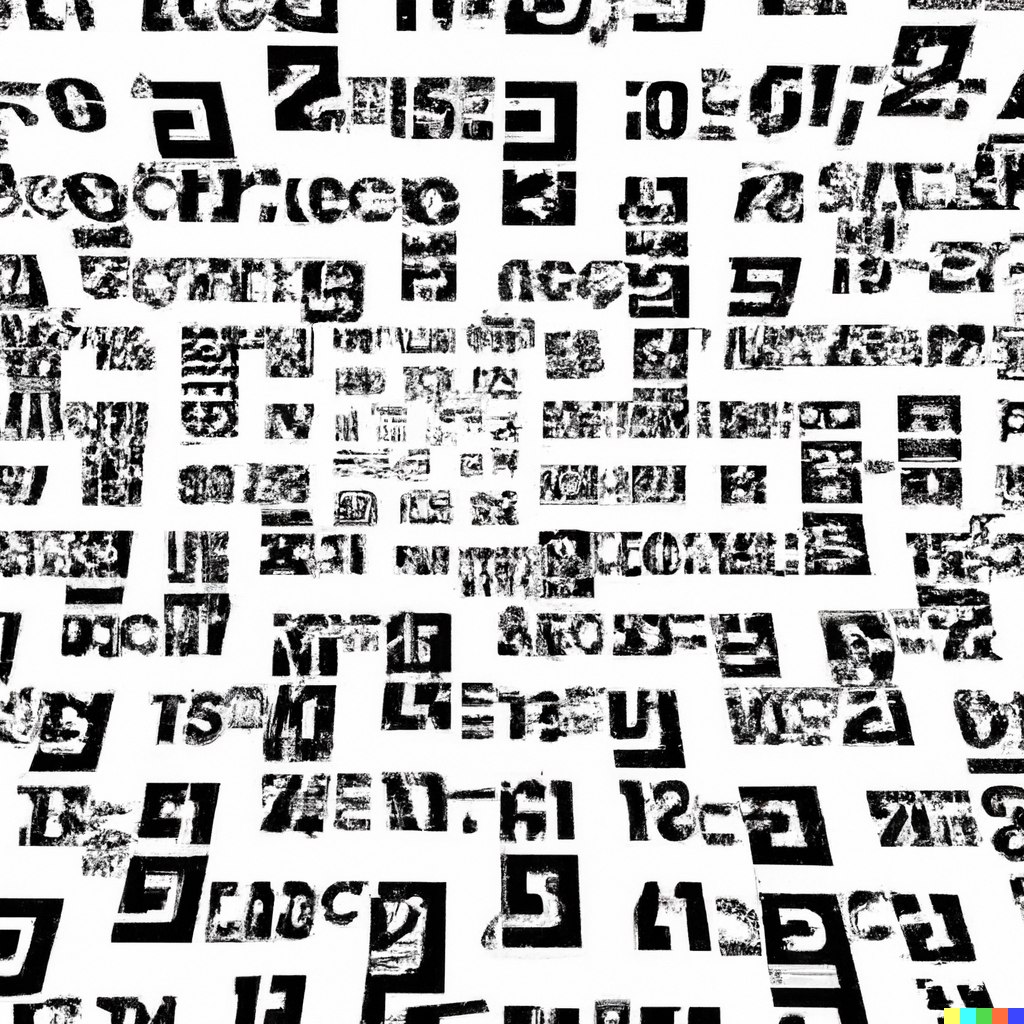

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Можно что-нибудь более реализуемое и менее ресурсозатратное для третьего? Хотя это больше похоже на жизненную ситуацию, где всё тлен